# Sentiment Analysis on Twitter data
### Contents
1. Abstract
2. Dataset
3. Goal
4. Importing Required libraries
5. Exploratory Data Analysis
6. Data Visualization
7. Feature Engineering and Data Processing
8. Tokenizing the words
9. Prediction Models
    - RandomForest Classifier
    - Linear Regression
    - Decision Tree classifier
    - XGBoost Classifier
8. Model Comparison

********************************

### Abstract
Sentiment analysis refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics. Twitter  is  one  of  the  social  media  that  is  gaining  popularity. Twitter offers organizations a fast and effective way to analyze customers’ perspectives toward the critical to success in the market place. Developing a program for sentiment analysis is an approach to be used to computationally measure customers’ perceptions.  

### Dataset
The dataset which is used here, is collected from Kaggle website. Here is the link of the dataset : https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech.

### Goal
The goal of this project is to detect hate speech in tweets using various prediction models. We say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.

********************************

### Importing required libraries and Dataset

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import string
from nltk.stem.porter import PorterStemmer

In [2]:
train = pd.read_csv('../Dataset/train.csv')
test = pd.read_csv('../Dataset/test.csv')

print(train.shape)
print(test.shape)

(31962, 3)
(17197, 2)


## Exploratory Data Analysis

In [3]:
df = pd.read_csv('../Dataset/train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [5]:
df.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
df['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

In [7]:
#checking for null values
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

There is NO NULL values in the dataset

In [8]:
#defining dependent and independent vectors
#taking only title for prediction
x = df.iloc[:,2:3]
y = df['label']
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [9]:
df.drop('id', axis=1, inplace=True)
df.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


<AxesSubplot:xlabel='label', ylabel='count'>

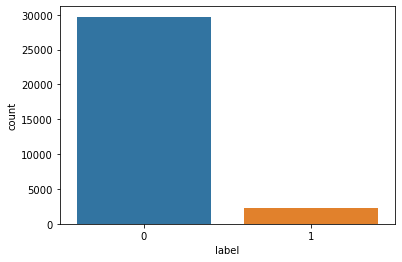

In [10]:
#checking number of tweets with labels 0 and 1
sns.countplot(x = 'label',data = df)

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

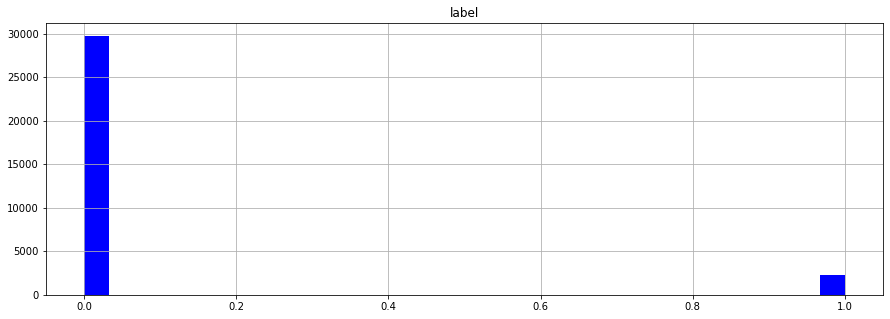

In [11]:
df.hist(bins=30, figsize=(15,5), color='b')

We observe that all the labels are discrete values of 0 and 1 as discussed earlier, hence this is binary class problem.

In [12]:
# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

,id,label,tweet,len
0,1,0,@user when a father is dysfunctional and is s...,102
1,2,0,@user @user thanks for #lyft credit i can't us...,122
2,3,0,bihday your majesty,21
3,4,0,#model i love u take with u all the time in ...,86
4,5,0,factsguide: society now #motivation,39
5,6,0,[2/2] huge fan fare and big talking before the...,116
6,7,0,@user camping tomorrow @user @user @user @use...,74
7,8,0,the next school year is the year for exams.ð...,143
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,87
9,10,0,@user @user welcome here ! i'm it's so #gr...,50


<AxesSubplot:ylabel='Frequency'>

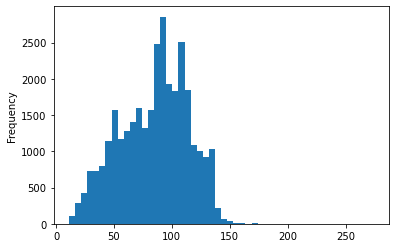

In [13]:
# plot a histogram on the character count/tweet length
train['len'].plot(bins=50, kind='hist')

Seems like majority of the tweets are between 70 to 100 character.

Lets seperate the positive and negative tweets in different lists.

In [14]:
positive = df[df['label']==0]
positive

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31956,0,off fishing tomorrow @user carnt wait first ti...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to...
31959,0,listening to sad songs on a monday morning otw...


In [15]:
negative = df[df['label']==1]
negative

,label,tweet
13,1,@user #cnn calls #michigan middle school 'buil...
14,1,no comment! in #australia #opkillingbay #se...
17,1,retweet if you agree!
23,1,@user @user lumpy says i am a . prove it lumpy.
34,1,it's unbelievable that in the 21st century we'...
...,...,...
31934,1,lady banned from kentucky mall. @user #jcpenn...
31946,1,@user omfg i'm offended! i'm a mailbox and i'...
31947,1,@user @user you don't have the balls to hashta...
31948,1,"makes you ask yourself, who am i? then am i a..."


In [16]:
sentences = df['tweet'].to_list()
sentences[:10]

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked",
 '  bihday your majesty',
 '#model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦  ',
 ' factsguide: society now    #motivation',
 '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  ',
 ' @user camping tomorrow @user @user @user @user @user @user @user dannyâ\x80¦',
 "the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl",
 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦ ',
 " @user @user welcome here !  i'm   it's so #gr8 ! "]

In [17]:
len(sentences)

31962

In [18]:
single_sentence = ' '.join(sentences)
single_sentence[:500]

" @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked   bihday your majesty #model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦    factsguide: society now    #motivation [2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo    @user c"

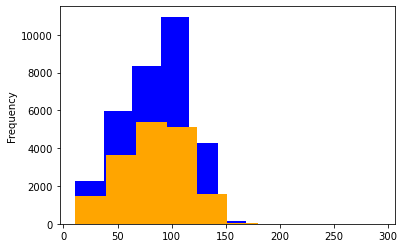

In [19]:
# checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'blue', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

In [20]:
train.groupby('label').describe()

id                                                               \
         count          mean          std   min      25%      50%       75%   
label                                                                         
0      29720.0  15974.454441  9223.783469   1.0  7981.75  15971.5  23965.25   
1       2242.0  16074.896075  9267.955758  14.0  8075.25  16095.0  24022.00   

                    len                                                        
           max    count       mean        std   min   25%   50%    75%    max  
label                                                                          
0      31962.0  29720.0  84.328634  29.566484  11.0  62.0  88.0  107.0  274.0  
1      31961.0   2242.0  90.187779  27.375502  12.0  69.0  96.0  111.0  152.0

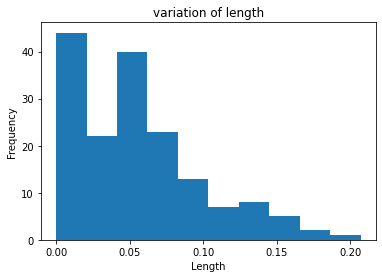

In [21]:
train.groupby('len').mean()['label'].plot.hist(figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

### Removing twitter handles

In [22]:
def remove_pattern(input_text,pattern):
    r= re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [23]:
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'],"@[\w]*") 
df.head()

,label,tweet,tidy_tweet
0,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation,factsguide: society now #motivation


In [24]:
df['tidy_tweet'] = df['tidy_tweet'].apply(
    lambda x: ' '.join([w for w in x.split() if len(w)>3])) #removing words whose length is less than 3
df.head()

,label,tweet,tidy_tweet
0,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,0,bihday your majesty,bihday your majesty
3,0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,0,factsguide: society now #motivation,factsguide: society #motivation


In [25]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x:x.split()) #it will split all words by whitespace
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, can't, cause, they, do...
2                              [bihday, your, majesty]
3    [#model, love, take, with, time, urð±!!!, ð...
4                  [factsguide:, society, #motivation]
Name: tidy_tweet, dtype: object

## Plotting frequently used words

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

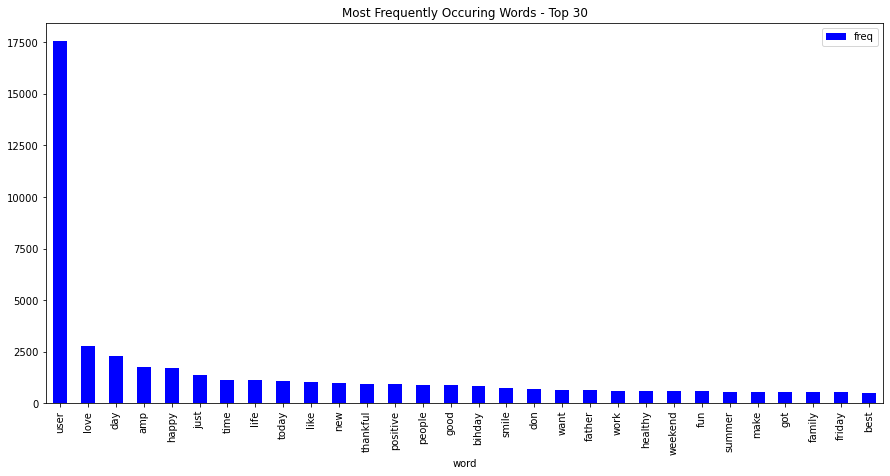

In [26]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

Text(0.5, 1.0, 'Words from Reviews')

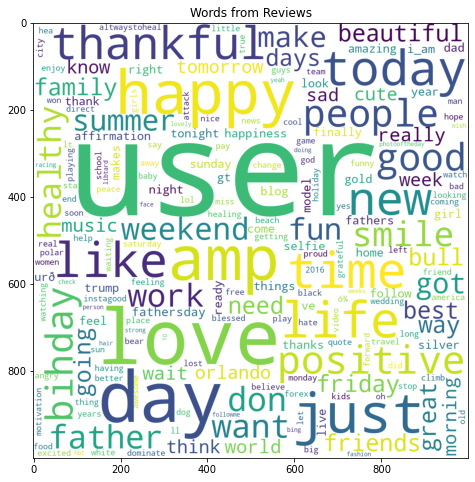

In [27]:
wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Words from Reviews")

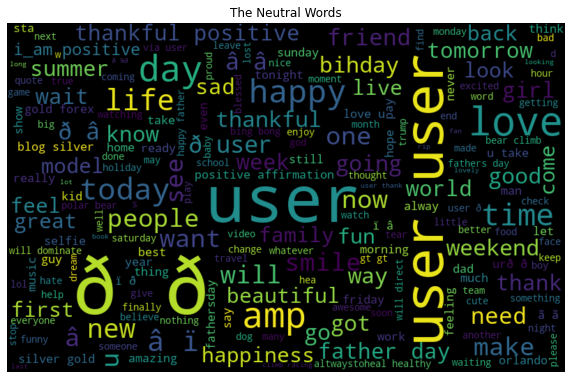

In [28]:
normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

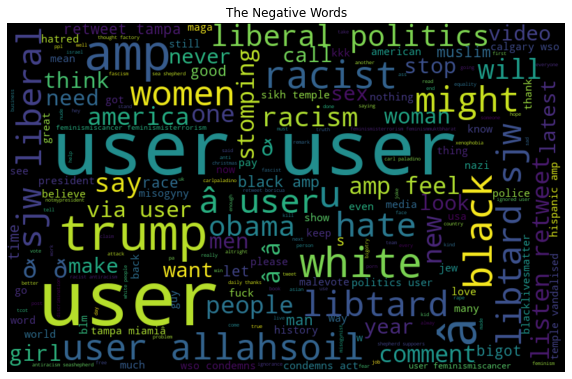

In [29]:
negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

### Feature Engineering and Data Pre-Processing 

In [30]:
# collecting the hashtags
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [31]:
# extracting hashtags from non racist tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from racist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

### Plotting frequent positive and negative hashtags

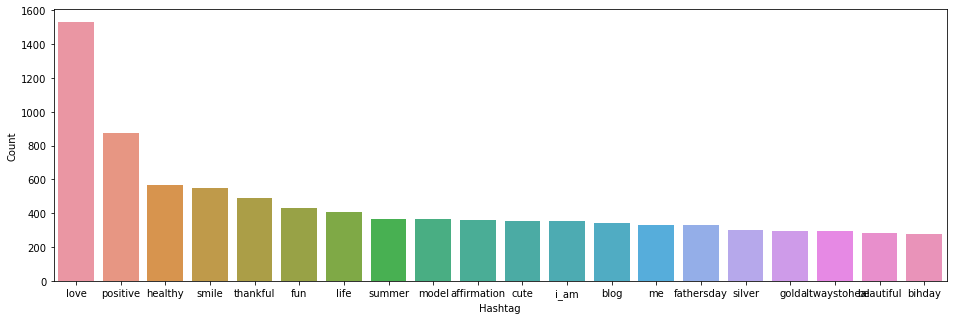

In [32]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

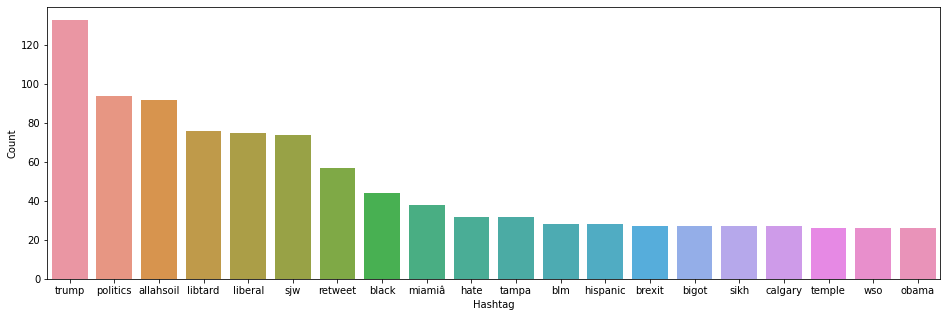

In [33]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

### Removing unwanted patterns

In [34]:
train_corpus = []

for i in range(0, 31962):
    review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
    review = review.lower()
    review = review.split()
  
    ps = PorterStemmer()
  
  # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
    review = ' '.join(review)
    train_corpus.append(review)

In [35]:
test_corpus = []

for i in range(0, 17197):
    review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
  
  # stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
    review = ' '.join(review)
    test_corpus.append(review)

## Tokenizing the words present in the training set

In [36]:
tokenized_twt = train['tweet'].apply(lambda x: x.split()) 

# a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_twt,
            #size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_twt, total_examples= len(train['tweet']), epochs=20)

(6110084, 8411580)

In [37]:
model_w2v.wv.most_similar(positive = "dinner")

[('spaghetti', 0.6849910616874695),
 ('#prosecco', 0.657981812953949),
 ('coaching', 0.6516597270965576),
 ('bay.', 0.6408182382583618),
 ('#wanderlust', 0.6322321891784668),
 ('dialogue', 0.6264631152153015),
 ('podium', 0.6232860088348389),
 ('spa', 0.6216394901275635),
 ('#marbs', 0.6140775680541992),
 ('later!', 0.6110490560531616)]

In [38]:
model_w2v.wv.most_similar(positive = "cancer")

[('law.', 0.7645754814147949),
 ('britain', 0.748203694820404),
 ('aol', 0.7439360022544861),
 ("society's", 0.7419885396957397),
 ('solution', 0.7414036989212036),
 ('absurd.', 0.7339345812797546),
 ('ways.', 0.7327361106872559),
 ('answer.', 0.7302213311195374),
 ('champion,', 0.7299770712852478),
 ('tolerance', 0.729868471622467)]

In [39]:
model_w2v.wv.most_similar(positive = "apple")

[('"mytraining"', 0.746671199798584),
 ('mytraining', 0.7405697107315063),
 ('training"', 0.729476809501648),
 ('app,', 0.673353374004364),
 ('app', 0.6509090065956116),
 ('"my', 0.6334691047668457),
 ('mp3', 0.612907350063324),
 ("domino's", 0.6021477580070496),
 ('canada!', 0.601526141166687),
 ('ð\x9f\x8eµð\x9f\x8e¶', 0.5995253920555115)]

In [40]:
model_w2v.wv.most_similar(negative = "hate")

[('â\x9c\x88ï¸\x8f', 0.045095231384038925),
 ('#community', 0.019875971600413322),
 ('ð\x9f\x8d»', 0.012863277457654476),
 ('#newyork', 0.012851756066083908),
 ('ð\x9f\x92\x8b', 0.009494286961853504),
 ('ma', 0.009234493598341942),
 ('#comeonengland', 0.004811285063624382),
 ('ð\x9f\x98\x8b', 0.0013442476047202945),
 ('#ireland', -0.003417418571189046),
 ('#festival', -0.006295271683484316)]

In [41]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import TaggedDocument

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

C:\Users\PRIYAL\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[TaggedDocument(words=['when', 'father', 'dysfunctional', 'selfish', 'drags', 'kids', 'into', 'dysfunction.', '#run'], tags=['tweet_0']),
 TaggedDocument(words=['thanks', '#lyft', 'credit', "can't", 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 TaggedDocument(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 TaggedDocument(words=['#model', 'love', 'take', 'with', 'time', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 TaggedDocument(words=['factsguide:', 'society', '#motivation'], tags=['tweet_4']),
 TaggedDocument(words=['[2/2]', 'huge', 'fare', 'talking', 'before', 'they', 'leave.', 'chaos', 'disputes', 'when', 'they', 'there.', '#allshowandnogo'], tags=['tweet_5'])]

## Count vectorizer
We need to extract or convert the text data into numbers without losing much of the information. One way to do such transformation is <b>Bag-Of-Words (BOW)</b> which gives a number to each word but that is very inefficient. So, a way to do it is by CountVectorizer: it counts the number of words in the document i.e it converts a collection of text documents to a matrix of the counts of occurences of each word in the document.

In [42]:
# creating bag of words

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

(31962, 2500)
(31962,)


In [43]:
# creating bag of words

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

(17197, 2500)


## Training and Prediction of data

In [44]:
# splitting the training data into train and valid sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(23971, 2500)
(7991, 2500)
(23971,)
(7991,)


## Standardization

In [45]:
# standardization
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)
print(x_test)

[[-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]
 [-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]
 [-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]
 ...
 [-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]
 [-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]
 [-0.02889703 -0.04482922 -0.03984678 ... -0.01864841 -0.02436517
  -0.02142658]]


## Prediction Models
### Random Forest classifier
A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap and Aggregation, known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.

In [46]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_valid)
a1= rfc.score(x_valid, y_valid)
print("Training Accuracy :", rfc.score(x_train, y_train))
print("Validation Accuracy :", rfc.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9526967838818671
F1 score : 0.6142857142857142
[[7312  120]
 [ 258  301]]


### Linear Regression
Linear regression is a linear model that assumes a linear relationship between the input variables (x) and the single output variable (y). Different techniques can be used to prepare or train the linear regression equation from data, the most common of which is called Ordinary Least Squares.

In [47]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_valid)
a2= lr.score(x_valid, y_valid)
print("Training Accuracy :", lr.score(x_train, y_train))
print("Validation Accuracy :", lr.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

C:\Users\PRIYAL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.9851487213716574
Validation Accuracy : 0.9416843949443123
f1 score : 0.5933682373472949
[[7185  247]
 [ 219  340]]


### Decision Tree Classifier


In [48]:
dc = DecisionTreeClassifier()
dc.fit(x_train, y_train)

y_pred = dc.predict(x_valid)
a3= dc.score(x_valid, y_valid)
print("Training Accuracy :", dc.score(x_train, y_train))
print("Validation Accuracy :", dc.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

Training Accuracy : 0.9991656585040257
Validation Accuracy : 0.9325491177574772
f1 score : 0.5381319622964867
[[7138  294]
 [ 245  314]]


### XGBoost Classifier
XGBoost is an implementation of Gradient Boosted decision trees. In this algorithm, decision trees are created in sequential form. Weights are assigned to all the independent variables which are then fed into the decision tree which predicts results. These individual classifiers/predictors then ensemble to give a strong and more precise model. It can work on regression, classification, ranking, and user-defined prediction problems.

In [49]:
model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)
a4= model.score(x_valid, y_valid)
print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

C:\Users\PRIYAL\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy : 0.9603687789412206
Validation Accuracy : 0.9555750218996371
f1 score : 0.5748502994011976
[[7396   36]
 [ 319  240]]


## Plotting of Classifier vs Accuracy graph for all classifiers

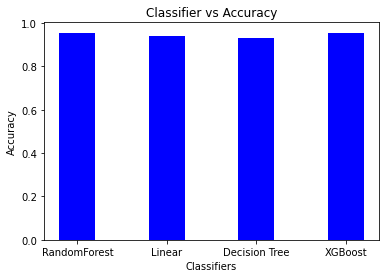

In [50]:
X_title = ['RandomForest','Linear','Decision Tree','XGBoost']
X_axis = np.arange(len(X_title))
acc=[a1,a2,a3,a4]

plt.bar(X_axis,acc, tick_label = X_title, width= 0.4,color='blue')

#plt.xticks(X_axis, X_title)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Classifier vs Accuracy")
plt.show()